<a href="https://colab.research.google.com/github/franz6ko/natural-lenguage-processing/blob/master/challenge_4_word_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.inove.com.ar"><img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center"></a>


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, CuDNNLSTM

### Datos
Utilizaremos como dataset los diálogos de varias películas de Marvel.

In [ ]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('./Marvel Datasets', os.F_OK) is False:
    if os.access('marvel_dataset.zip', os.F_OK) is False:
        url = 'https://drive.google.com/uc?id=1BsAIgNChI16FiV5rBVCTEoavEP5gdnLL&authuser=0&export=download'
        output = 'marvel_dataset.zip'
        gdown.download(url, output, quiet=False)
    !unzip -q marvel_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [ ]:
# Peliculas incluidas
import glob
all_files = glob.glob("./Marvel Datasets/*")

print("Nº total de peliculas", len(all_files))

n = 4
print("Usando", n, "peliculas")

all_files = all_files[:n]
all_files

Nº total de peliculas 23
Usando 4 peliculas


['./Marvel Datasets/Spider-Man.Far.From.Home.txt',
 './Marvel Datasets/Guardians.of.the.Galaxy.Vol. 2.txt',
 './Marvel Datasets/Spider-Man.Homecoming.txt',
 './Marvel Datasets/Captain.America.Civil.War.txt']

In [ ]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
li = []

for filename in all_files:
    df = pd.read_csv(filename, sep='/n', header=None, engine="python")
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df.head()

,0
0,"Nick, this was a tragedy, but it's not why we'..."
1,"What, are we fighting the weather now?"
2,Locals say the cyclone had a face.
3,People see things when they're under stress.
4,That does not mean that this is the start to s...


In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 7518


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [ ]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [ ]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     Nick, this was a tragedy, but it's not why we'...
1                What, are we fighting the weather now?
2                    Locals say the cyclone had a face.
3          People see things when they're under stress.
4     That does not mean that this is the start to s...
5                                          Who are you?
6                      You don't want any part of this.
7                               Gone but not forgotten.
8           Thanks to Kenneth Lim and Vihaan Ramamurthy
9      for their help with that touching video tribute.
10    This year has been nothing short of ***. It is...
11                                         Jason. What?
12                                         No swearing.
13             It's the last day of school. We're good.
14                                            Historic.
15    Over five years ago, half of all life in the u...
Name: 0, dtype: object

In [ ]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Nick, this was a tragedy, but it\'s not why we\'re here. What, are we fighting the weather now? Locals say the cyclone had a face. People see things when they\'re under stress. That does not mean that this is the start to some other big world-ending Who are you? You don\'t want any part of this. Gone but not forgotten. Thanks to Kenneth Lim and Vihaan Ramamurthy for their help with that touching video tribute. This year has been nothing short of ***. It is crazy. It\'s insane. Jason. What? No swearing. It\'s the last day of school. We\'re good. Historic. Over five years ago, half of all life in the universe, including our own Midtown High, was wiped from existence. Then eight months ago, a band of brave heroes brought us back. They called it "the Blip." Those of us who Blipped away came back the same age But our classmates that didn\'t Blip had grown five years older. My little brother is now older than me. Yeah, it\'s math. Even though we had Blipped away halfway through the school y

In [ ]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['nick',
 'this',
 'was',
 'a',
 'tragedy',
 'but',
 "it's",
 'not',
 'why',
 "we're",
 'here',
 'what',
 'are',
 'we',
 'fighting',
 'the',
 'weather',
 'now',
 'locals',
 'say']

In [ ]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 43335


In [ ]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [ ]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['nick', 'this', 'was', 'a'],
 ['this', 'was', 'a', 'tragedy'],
 ['was', 'a', 'tragedy', 'but'],
 ['a', 'tragedy', 'but', "it's"],
 ['tragedy', 'but', "it's", 'not'],
 ['but', "it's", 'not', 'why'],
 ["it's", 'not', 'why', "we're"],
 ['not', 'why', "we're", 'here'],
 ['why', "we're", 'here', 'what'],
 ["we're", 'here', 'what', 'are'],
 ['here', 'what', 'are', 'we'],
 ['what', 'are', 'we', 'fighting'],
 ['are', 'we', 'fighting', 'the'],
 ['we', 'fighting', 'the', 'weather'],
 ['fighting', 'the', 'weather', 'now'],
 ['the', 'weather', 'now', 'locals'],
 ['weather', 'now', 'locals', 'say'],
 ['now', 'locals', 'say', 'the'],
 ['locals', 'say', 'the', 'cyclone'],
 ['say', 'the', 'cyclone', 'had']]

In [ ]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[543, 13, 22, 5],
 [13, 22, 5, 1591],
 [22, 5, 1591, 40],
 [5, 1591, 40, 19],
 [1591, 40, 19, 20],
 [40, 19, 20, 77],
 [19, 20, 77, 78],
 [20, 77, 78, 44],
 [77, 78, 44, 11],
 [78, 44, 11, 24],
 [44, 11, 24, 23],
 [11, 24, 23, 724],
 [24, 23, 724, 3],
 [23, 724, 3, 2311],
 [724, 3, 2311, 58],
 [3, 2311, 58, 2312],
 [2311, 58, 2312, 114],
 [58, 2312, 114, 3],
 [2312, 114, 3, 1198],
 [114, 3, 1198, 115]]

In [ ]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 43331


### 3 - Input y target

In [ ]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [ ]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [ ]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [ ]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(43331, 3)
(43331,)


In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'to',
 5: 'a',
 6: 'it',
 7: 'that',
 8: 'and',
 9: 'of',
 10: 'is',
 11: 'what',
 12: 'me',
 13: 'this',
 14: "i'm",
 15: 'in',
 16: 'on',
 17: 'no',
 18: 'my',
 19: "it's",
 20: 'not',
 21: 'yeah',
 22: 'was',
 23: 'we',
 24: 'are',
 25: 'your',
 26: 'have',
 27: 'know',
 28: "don't",
 29: 'all',
 30: 'be',
 31: 'do',
 32: 'for',
 33: 'so',
 34: 'okay',
 35: 'he',
 36: 'just',
 37: "you're",
 38: 'right',
 39: 'oh',
 40: 'but',
 41: 'hey',
 42: 'like',
 43: 'with',
 44: 'here',
 45: 'up',
 46: "that's",
 47: 'go',
 48: 'out',
 49: 'man',
 50: 'if',
 51: 'gonna',
 52: 'can',
 53: 'get',
 54: 'about',
 55: 'one',
 56: 'got',
 57: 'come',
 58: 'now',
 59: 'him',
 60: 'peter',
 61: 'how',
 62: 'they',
 63: 'who',
 64: 'there',
 65: 'us',
 66: 'good',
 67: "he's",
 68: 'look',
 69: 'did',
 70: 'really',
 71: 'would',
 72: 'from',
 73: 'see',
 74: 'because',
 75: 'need',
 76: 'at',
 77: 'why',
 78: "we're",
 79: 'them',
 80: 'will',
 81: 'spider',
 82: 'a

In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

4595

In [ ]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size)

IndexError: ignored

In [ ]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [ ]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(43331, 4595)

### 4 - Entrenar el modelo

In [ ]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [ ]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

4595

In [ ]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=10, input_length=input_seq_len))

model.add(CuDNNLSTM(64, return_sequences=True))
model.add(Dropout(0.2))
# model.add(CuDNNLSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
model.add(CuDNNLSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='leaky_relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 10)             45960     
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 3, 64)             19456     
_________________________________________________________________
dropout (Dropout)            (None, 3, 64)             0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 64)                33280     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 4595)              151635    
Total params: 252,411
Trainable params: 252,411
Non-trainable params: 0
__________________________________________________

In [ ]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
1890/1890 [==============================] - 32s 16ms/step - loss: 6.4761 - accuracy: 0.0439 - val_loss: 6.6214 - val_accuracy: 0.0529
Epoch 2/50
1890/1890 [==============================] - 25s 13ms/step - loss: 5.9249 - accuracy: 0.0720 - val_loss: 6.5444 - val_accuracy: 0.0781
Epoch 3/50
1890/1890 [==============================] - 24s 13ms/step - loss: 5.6805 - accuracy: 0.0889 - val_loss: 6.6000 - val_accuracy: 0.0840
Epoch 4/50
1890/1890 [==============================] - 25s 13ms/step - loss: 5.5198 - accuracy: 0.0981 - val_loss: 6.6180 - val_accuracy: 0.0934
Epoch 5/50
1890/1890 [==============================] - 24s 13ms/step - loss: 5.3959 - accuracy: 0.1054 - val_loss: 6.6924 - val_accuracy: 0.0982
Epoch 6/50
1890/1890 [==============================] - 24s 13ms/step - loss: 5.2881 - accuracy: 0.1113 - val_loss: 6.7423 - val_accuracy: 0.0994
Epoch 7/50
1890/1890 [==============================] - 23s 12ms/step - loss: 5.2049 - accuracy: 0.1145 - val_loss: 6.8185 -

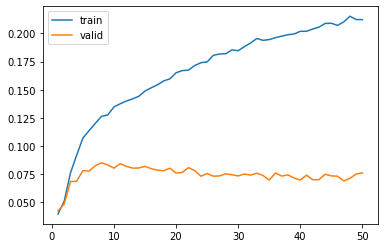

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://56955.gradio.app
Interface loading below...


KeyboardInterrupt: ignored

### 6 - Generación de secuencias nuevas

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [ ]:
input_text='hey'

generate_seq(model, tok, input_text, max_length=3, n_words=5)

'hey but you have to be'

In [ ]:
input_text="we didn't"

generate_seq(model, tok, input_text, max_length=3, n_words=1)

"we didn't because"

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.